# Investigation Into the Most Significant Indicators of Heart Disease 

Baiya Griffiths - 26409599\
Grace Li - 62540075\
Andrew Wang - 91790451\
Zhaolan Wang - 70239009

In this project we are looking at Coronary artery disease, a common heart disease where the major blood vessels are clogged or narrowed. Due to the blockage it is difficult to transfer oxygen, blood and nutrients to the heart. Usually this disease can be attributed to cholesterol deposits, so the level of cholesterol in potential victims is of interest to us. The symptoms of coronary artery disease are often reflected in the type of chest pain, resting blood pressure, max heart rate and so on.

Question: Based on a limited set of test data, is a person at risk for coronary heart disease?
We will aim to identify an easily attainable set of variables that lead to an accurate prediction of heart disease. This could be used as an initial screening to determine risk of heart disease and prioritise additional testing to people at higher risk. We are going to take the data with different variables to train, test, and find the accuracy to determine which set of variables can be used for effective screening. 

The dataset we chose was the one about heart disease. The database for heart disease contains 76 attributes (variables), but the dataset we are using includes only 14 of them. In our project, we will focus on determining the presence or absence of heart disease, so the data in the disease column has only two categories, 0 (no heart disease) and 1 (with heart disease). Also, this database has four regional datasets, and we finally chose the Hungarian regional. 

In [8]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(tidymodels)
require(gridExtra)

In [9]:
#First step is to read the data and label the column names. 
heart_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",col_name = FALSE)
colnames(heart_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fbs>120mg/dL", "restingecg", "max_heart_rate", "exercise_induced_angina", "oldpeak", "slope", "ca", "thal", "disease")

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
#Here we are tidying the data by filtering out columns with "?" and selecting which columns we want. 
heart_data_tidy <- heart_data |> select(chest_pain, resting_bp, cholesterol, restingecg, max_heart_rate, disease) |>
                   filter(chest_pain!= "?", resting_bp!= "?", cholesterol!= "?", restingecg!= "?", max_heart_rate!= "?", disease!= "?") |>
                   mutate(chest_pain = as.numeric(chest_pain), 
                          resting_bp = as.numeric(resting_bp),
                          cholesterol = as.numeric(cholesterol),
                          restingecg = as.numeric(restingecg),
                          max_heart_rate = as.numeric(max_heart_rate),
                          disease = as_factor(disease))

In [11]:
heart_split <- initial_split(heart_data_tidy, prop = .75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)
heart_train

chest_pain,resting_bp,cholesterol,restingecg,max_heart_rate,disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,130,132,2,185,0
2,120,243,0,160,0
2,100,219,1,150,0
⋮,⋮,⋮,⋮,⋮,⋮
4,160,331,0,94,1
3,130,294,1,100,1
4,155,342,0,150,1


In [12]:
#Preliminary exploratory data analysis; missing values were ommited so there are zero rows with missing values
#Finding mean of all numerical predictors
heart_data_miss_num <- heart_train |>
                       map_df(is.na) |>
                       map_df(sum)
heart_data_miss_num

heart_data_obs_num <- heart_train |>
                      summarize(n_cp=n(),n_rbp=n(),n_cholesterol=n(),n_max_heart_rate=n(),n_disease=n())
heart_data_obs_num

heart_data_mean <- heart_train |>
    select(resting_bp, cholesterol, max_heart_rate) |>
    map_dfr(mean)
heart_data_mean

#Finding number of observations for each class
heart_num_class <- heart_train |>
    group_by(disease) |>
    summarize(n=n())
heart_num_class

chest_pain,resting_bp,cholesterol,restingecg,max_heart_rate,disease
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


n_cp,n_rbp,n_cholesterol,n_max_heart_rate,n_disease
<int>,<int>,<int>,<int>,<int>
201,201,201,201,201


resting_bp,cholesterol,max_heart_rate
<dbl>,<dbl>,<dbl>
132.0896,247.4527,139.8706


disease,n
<fct>,<int>
0,126
1,75


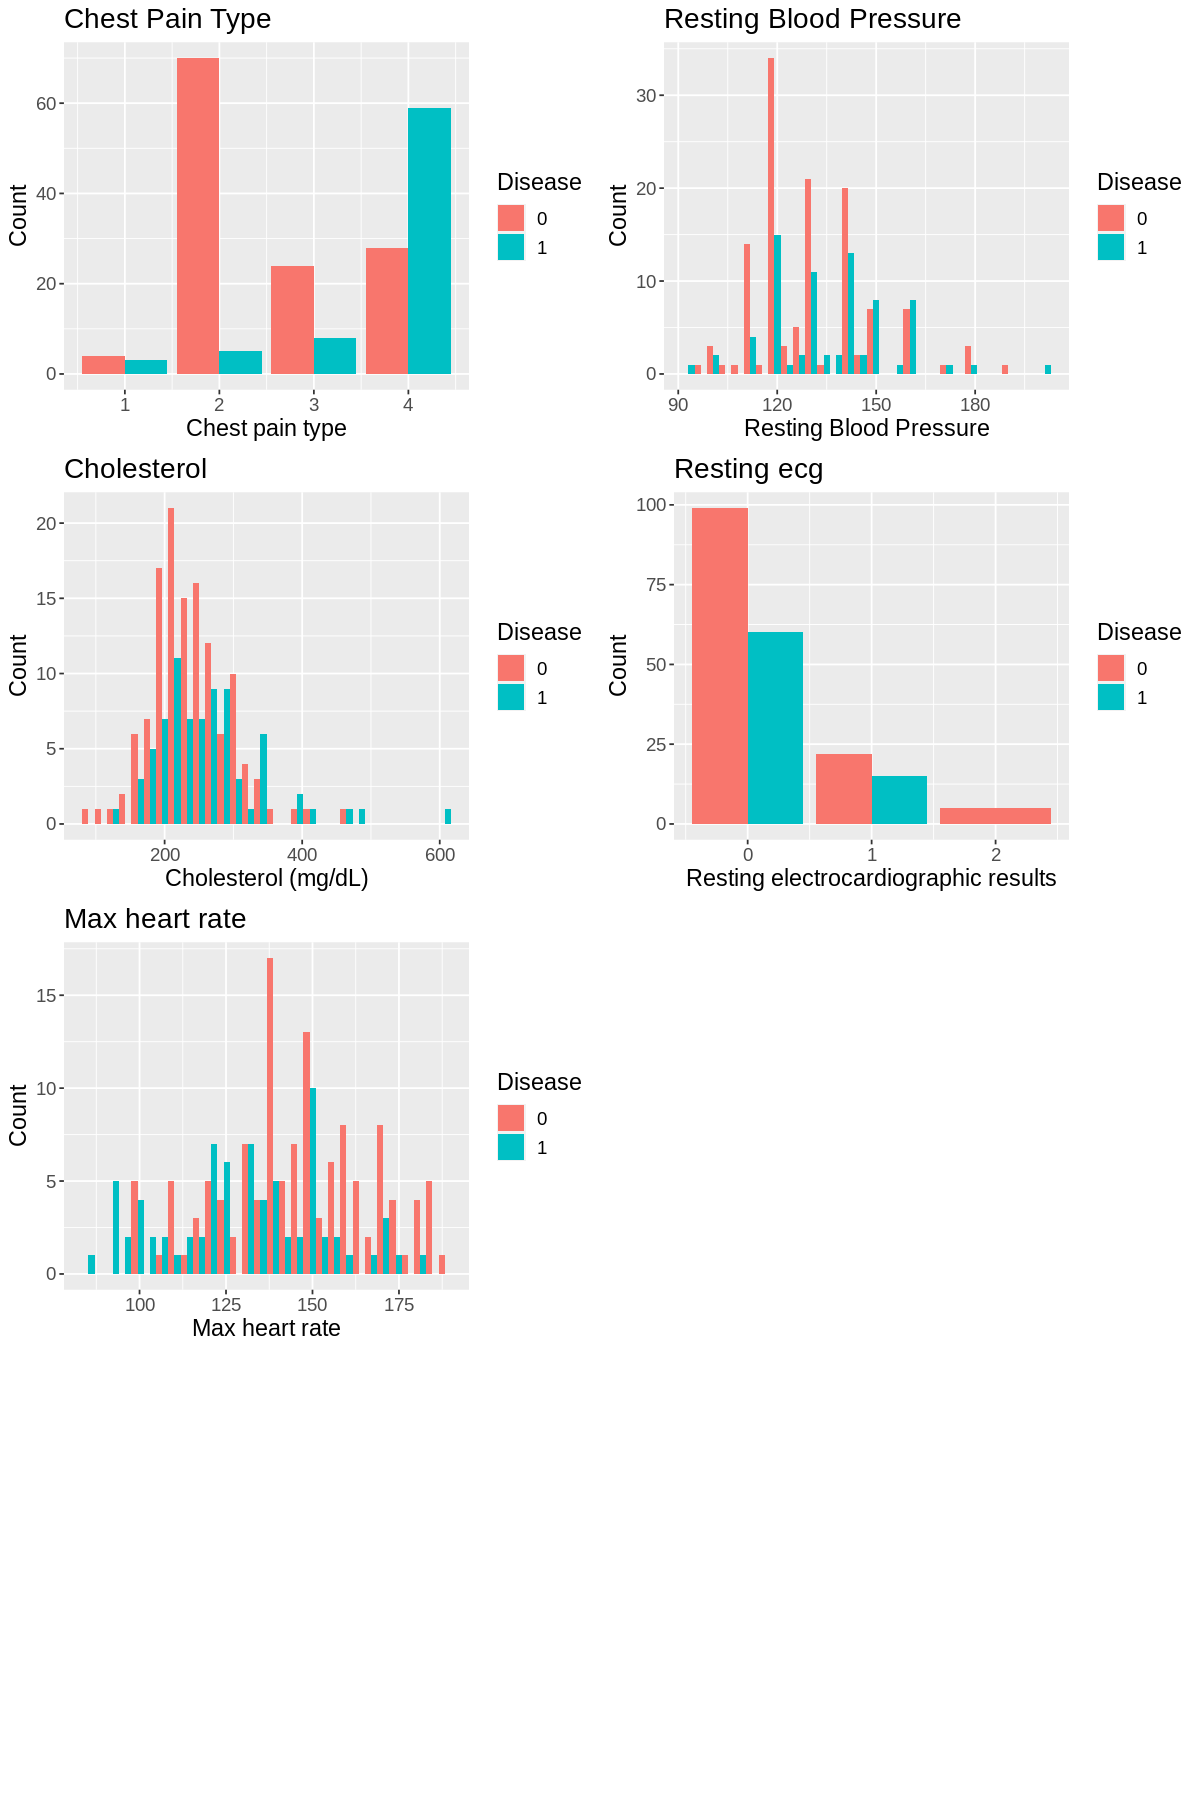

In [19]:
#Preliminary exploratory data analysis; visualization of predictor distribution
options(repr.plot.height = 15, repr.plot.width = 10)
chest_pain_plot <- ggplot(heart_train , 
                   aes(x = chest_pain, fill = disease)) +
                   geom_bar(position= "dodge") +
                   labs(x = "Chest pain type", y = "Count",  fill = "Disease") +
                   ggtitle("Chest Pain Type") +
                   theme(text = element_text(size = 14))
restingbp_plot <- ggplot(heart_train , 
                   aes(x = resting_bp, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Resting Blood Pressure", y = "Count",  fill = "Disease") +
                   ggtitle("Resting Blood Pressure") +
                   theme(text = element_text(size = 14))
chol_plot <- ggplot(heart_train , 
                   aes(x = cholesterol, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Cholesterol (mg/dL)", y = "Count",  fill = "Disease") +
                   ggtitle("Cholesterol") +
                   theme(text = element_text(size = 14))
restingecg_plot <- ggplot(heart_train , 
                   aes(x = restingecg, fill = disease)) +
                   geom_bar(position= "dodge") +
                   labs(x = "Resting electrocardiographic results", y = "Count",  fill = "Disease") +
                   ggtitle("Resting ecg") +
                   theme(text = element_text(size = 14))
max_heart_rate_plot <- ggplot(heart_train , 
                   aes(x = max_heart_rate, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Max heart rate", y = "Count",  fill = "Disease") +
                   ggtitle("Max heart rate") +
                   theme(text = element_text(size = 14))
grid.arrange(chest_pain_plot, restingbp_plot, chol_plot, restingecg_plot, max_heart_rate_plot ,nrow=4)

As we conduct our data analysis, we will use the k-nearest neighbours method with the five predictors mentioned in the above section. The value of k will not be chosen arbitrarily, rather, we will tune our classifier using cross-validation to ensure the most accurate value for k is used. The five predictors we are using were chosen based on research into the primary causes for heart disease. Two are categorical, and three are numerical. All predictors will be standardized.\
\
As part of the visualization of our results, we will include a visualization of the confusion matrix for the classifier. This will demonstrate the proportion of errors that our classifier makes.





Expected outcomes and significance:


What we expect to find:
We want to find out which predictors have the highest accuracy to determine whether a person has heart disease or not. Is this classifier reliable and can we apply it in practice?

Impact our findings could have:
If we get a classifier that is very accurate and can be used in practice, then our classifier can be used in hospitals to help doctors determine more accurately whether a patient has heart disease and to reduce their workload (by relying on the classifier for simple judgments).\


Future Questions:
Are there other tests that could be performed to create a more accurate screening? 
Could our screening be simplified even more such that a patient could be evaluated before being brought to the hospital?
How effective would this screening be applied to different groups of people (outside the Hungarian dataset we analyzed)? 
